In [1]:
import os, sys
import numpy as np
import pandas as pd
import gzip
from scipy.sparse import save_npz, load_npz

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

# sys.path.append("../../")
from os.path import dirname
curr_dir = os.path.abspath("")
base_dir = dirname(dirname(dirname(curr_dir)))
print(f"base_dir: {base_dir}")
sys.path.append(base_dir)
from go_annotation.ontology import ontology

%matplotlib inline

base_dir: /home/jlaw/projects/2020-01-deepgreen/fairseq-uniparc-fork


In [17]:
import importlib
importlib.reload(ontology)

<module 'go_annotation.ontology.ontology' from '/home/jlaw/projects/2020-01-deepgreen/fairseq-uniparc-fork/go_annotation/ontology/ontology.py'>

## Setup the GO annotation data

1. Propagate the annotations up the DAG
2. Create a sparse matrix representation

In [57]:
ann_dir = "/projects/deepgreen/jlaw/inputs/goa/2021-05"
goa_file = os.path.join(ann_dir, "2021-04-12-goa_uniprot_all-EXPC-HT.gaf.gz")
column_names = ["DB", "DB_Object_ID", "DB_Object_Symbol", "Qualifier", "GO_ID", "DB:Reference", "Evidence Code", "With (or) From", "Aspect", "DB_Object_Name", "DB_Object_Synonym", "DB_Object_Type", "Taxon and Interacting taxon", "Date", "Assigned_By", "Annotation_Extension", "Gene_Product_Form_ID"]
df = pd.read_csv(goa_file, sep='\t', names=column_names)

In [58]:
df.head()

,DB,DB_Object_ID,DB_Object_Symbol,Qualifier,GO_ID,DB:Reference,Evidence Code,With (or) From,Aspect,DB_Object_Name,DB_Object_Synonym,DB_Object_Type,Taxon and Interacting taxon,Date,Assigned_By,Annotation_Extension,Gene_Product_Form_ID
0,UniProtKB,A0A0R4IJ04,rbm14b,involved_in,GO:0030509,PMID:31636951,IGI,ZFIN:ZDB-GENE-050522-496,P,RNA-binding motif protein 14b,rbm14b,protein,taxon:7955,20201001,ZFIN,part_of(GO:0009953),NaN
1,UniProtKB,A0A0S2Z444,AGFG1,located_in,GO:0043231,GO_REF:0000052,IDA,NaN,C,Arf-GAP domain-containing protein,AGFG1,protein,taxon:9606,20131205,HPA,NaN,NaN
2,UniProtKB,A0A158VE51,c1qc,involved_in,GO:0006958,PMID:20615881,IDA,NaN,P,Complement C1q subcomponent subunit A,c1qc,protein,taxon:7955,20100924,ZFIN,NaN,NaN
3,UniProtKB,A0A178UNT9,AXX17_At5g58340,enables,GO:0005515,PMID:32612234,IPI,UniProtKB:Q9S7U9,F,Protein kinase domain-containing protein,AXX17_At5g58340|At5g58950|AN1_LOCUS26194|AT994...,protein,taxon:3702,20210403,IntAct,NaN,NaN
4,UniProtKB,A0A178UNT9,AXX17_At5g58340,enables,GO:0005515,PMID:32612234,IPI,UniProtKB:O23160,F,Protein kinase domain-containing protein,AXX17_At5g58340|At5g58950|AN1_LOCUS26194|AT994...,protein,taxon:3702,20210403,IntAct,NaN,NaN


In [59]:
df = df[df['DB'] == 'UniProtKB']

In [60]:
df['Evidence Code'].value_counts()

IDA    364264
IPI    353095
IMP    242568
TAS    145883
IGI     44705
HDA     38574
IEP     23407
IC       7305
EXP      2984
HMP      2480
HEP      1057
IEA       488
HGI        64
IBA        15
ISS        10
Name: Evidence Code, dtype: int64

In [61]:
# make sure not to include the NOT annotations
# df['Qualifier'].value_counts()
qualifiers = df['Qualifier'].unique()
not_ann = [x for x in qualifiers if 'NOT' in str(x)]
print("removing ", not_ann)
print(f"{len(df)}")
df = df[~df['Qualifier'].isin(not_ann)]
print(f"{len(df)}")

removing  ['NOT|enables', 'NOT|involved_in', 'NOT|acts_upstream_of_or_within', 'NOT|part_of', 'NOT|located_in', 'NOT|colocalizes_with', 'NOT|contributes_to', 'NOT|acts_upstream_of', 'NOT|acts_upstream_of_or_within_negative_effect']
1226899
1222460


In [62]:
# extract out the info we need to build the dataset
df = df[['DB_Object_ID', 'GO_ID', 'Aspect']]
df.columns = ['prot', 'term', 'hierarhcy']

In [63]:
terms = sorted(df['term'].unique())
len(terms)

27540

In [78]:
import importlib
importlib.reload(ontology)

<module 'go_annotation.ontology.ontology' from '/home/jlaw/projects/2020-01-deepgreen/fairseq-uniparc-fork/go_annotation/ontology/ontology.py'>

In [79]:
go_obo_file = f"{base_dir}/inputs/2021-05-swissprot/2021-05-25-go.obo.gz"
terms_file = f"{base_dir}/inputs/2021-05-swissprot/terms.csv.gz"
ont_obj = ontology.Ontology(obo_file=go_obo_file)
mapped_terms = ont_obj.map_and_filter_terms(terms)
anc_terms = ont_obj.get_ancestors(mapped_terms)
print(len(anc_terms))
terms = sorted(anc_terms)

reading obo file: /home/jlaw/projects/2020-01-deepgreen/fairseq-uniparc-fork/inputs/2021-05-swissprot/2021-05-25-go.obo.gz
27540 mapped to 27535 terms (2 terms skipped)
31442


In [80]:
# write these terms
os.makedirs(dirname(terms_file), exist_ok=True)
with gzip.open(terms_file, 'wb') as out:
    out.write(('\n'.join(anc_terms)+'\n').encode())

In [81]:
# now create another ontology object with only the part of the ontology with annotations
ont_obj = ontology.Ontology(obo_file=go_obo_file, restrict_terms_file=terms_file)

reading obo file: /home/jlaw/projects/2020-01-deepgreen/fairseq-uniparc-fork/inputs/2021-05-swissprot/2021-05-25-go.obo.gz
	Reading restrict_terms_file: /home/jlaw/projects/2020-01-deepgreen/fairseq-uniparc-fork/inputs/2021-05-swissprot/terms.csv.gz


In [82]:
# now build the annotation matrix and propagate annotations upward
prots, leaf_ann_mat = ontology.build_ann_matrix(df, ont_obj)
ann_mat = ontology.propagate_ann_up_dag(leaf_ann_mat, ont_obj.dag_matrix.T)

	4 annotations missed (2) terms


In [86]:
# UPDATE: limit terms to those with at least 10 annotations
terms50_file = f"{base_dir}/inputs/2021-05-swissprot/terms_10ann.txt.gz"
num_ann_per_term = np.ravel(ann_mat.sum(axis=0))
# print(num_ann_per_prot)
S = pd.Series(num_ann_per_term)
S = S[S >= 10]
print(f"{len(S)} terms with >= 10 annotations")
terms_idx = np.asarray(S.index)
with gzip.open(terms50_file, 'w') as out:
    out_str = '\n'.join(ont_obj.terms[idx] for idx in terms_idx) + '\n'
    out.write(out_str.encode())

14775 terms with >= 10 annotations


In [84]:
ann_mat_50 = ann_mat[:,terms_idx]
print(f"{len(ann_mat.data)} dropped to {len(ann_mat_50.data)} after limiting to terms with 10 or more annotations")
print(ann_mat_50.shape)

5562904 dropped to 5506109 after limiting to terms with 10 or more annotations
(137934, 14775)


In [87]:
ont_obj_50 = ontology.Ontology(obo_file=go_obo_file, restrict_terms_file=terms50_file)

reading obo file: /home/jlaw/projects/2020-01-deepgreen/fairseq-uniparc-fork/inputs/2021-05-swissprot/2021-05-25-go.obo.gz
	Reading restrict_terms_file: /home/jlaw/projects/2020-01-deepgreen/fairseq-uniparc-fork/inputs/2021-05-swissprot/terms_10ann.txt.gz


Text(0.5, 0, '# Annotations per term')

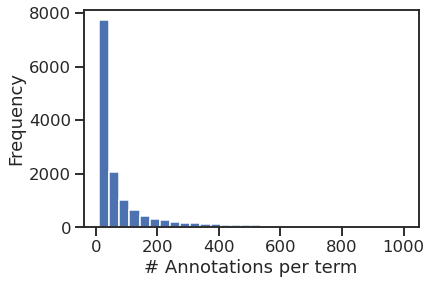

In [88]:
# plot the number of annotations per prot
num_ann_per_term = np.ravel(ann_mat_50.sum(axis=0))
# print(num_ann_per_prot)
S = pd.Series(num_ann_per_term)
S[S < 1000].plot.hist(bins=30)
plt.xlabel("# Annotations per term")
# swissprot_annotated.length.plot.hist(range=(0, 2048), bins=30)

In [21]:
# alternate approach to build the propagated annotation matrix:
# from tqdm import tqdm

# from scipy.sparse import coo_matrix, save_npz

# def get_sparse_indices(df, prot_indices):
#     for (i, prot, term) in tqdm(df.itertuples()):
#         prot_index = prot_indices[prot]
#         for term_index in ont.terms_to_indices(ont.get_ancestors(term)):
#             yield (prot_index, term_index)
            
# def get_csr_matrix(df):
#     prots = sorted(df['prot'].unique())
#     prot_indices = {prot: i for i, prot in enumerate(prots)}
#     indices = np.array(list(get_sparse_indices(df, prot_indices)))
#     values = np.ones(len(indices))
#     cm = coo_matrix((values, (indices[:, 0], indices[:, 1])), shape=(len(prots), ont.total_nodes))
#     return cm.asformat('csr')

# prot_term_pairs = df[['prot', 'term']]
# peter_ann_mat = get_csr_matrix(prot_term_pairs)


386197it [00:12, 30200.50it/s]


Text(0.5, 0, '# Annotations per prot')

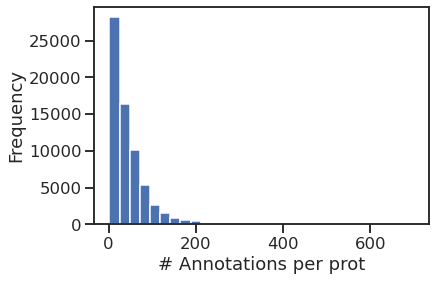

In [41]:
# plot the number of annotations per prot
num_ann_per_prot = np.ravel(ann_mat.sum(axis=1))
# print(num_ann_per_prot)
S = pd.Series(num_ann_per_prot)
S.plot.hist(bins=30)
plt.xlabel("# Annotations per prot")
# swissprot_annotated.length.plot.hist(range=(0, 2048), bins=30)

Text(0.5, 0, '# Annotations per term')

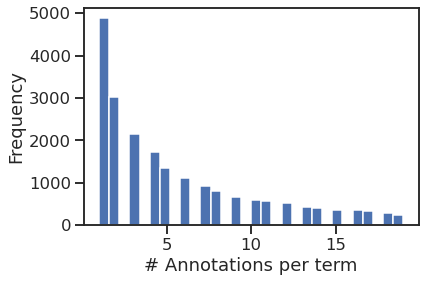

In [89]:
# and plot the number of annotations per term
num_ann_per_term = np.ravel(ann_mat.sum(axis=0))
# print(num_ann_per_prot)
S = pd.Series(num_ann_per_term)
S = S[S < 20]
S.plot.hist(bins=30)
plt.xlabel("# Annotations per term")
# swissprot_annotated.length.plot.hist(range=(0, 2048), bins=30)

In [90]:
S = pd.Series(num_ann_per_term)
print(len(S[S < 5]))

11785


In [91]:
print(len(S[S < 10]))

16667


In [92]:
print(len(S[S >= 10]))

14775


In [93]:
print(len(S[S >= 50]))

6472


In [94]:
ann_mat.shape

(137934, 31442)

In [95]:
num_ann_per_term.argmax()

3208

In [96]:
# biological process
ont_obj.terms[3208]

'GO:0008150'

In [97]:
# quick manual check for the first protein in the list that the annotations are correct
print(prots[0])
terms = np.asarray(ont_obj.terms)
ann_idx = ann_mat[0,:].nonzero()[1]
print(terms[ann_idx])

A0A009IHW8
['GO:0006796' 'GO:0044249' 'GO:0044248' 'GO:0009056' 'GO:0003674'
 'GO:0055086' 'GO:0009166' 'GO:1901362' 'GO:0044271' 'GO:0008150'
 'GO:0019438' 'GO:0016799' 'GO:0044237' 'GO:0019439' 'GO:0009058'
 'GO:0044281' 'GO:0009987' 'GO:1901564' 'GO:0034655' 'GO:1901576'
 'GO:0019362' 'GO:0044270' 'GO:0046700' 'GO:0019677' 'GO:0003824'
 'GO:0016798' 'GO:0072526' 'GO:0072524' 'GO:0006725' 'GO:0046496'
 'GO:0018130' 'GO:1901575' 'GO:1901292' 'GO:0034654' 'GO:0019637'
 'GO:0009117' 'GO:0019364' 'GO:1901565' 'GO:0046434' 'GO:0006753'
 'GO:0006807' 'GO:0044238' 'GO:1901361' 'GO:0003953' 'GO:0006793'
 'GO:0016787' 'GO:0008152' 'GO:1901360' 'GO:0044283' 'GO:0071704'
 'GO:0034404' 'GO:0046483' 'GO:0006139' 'GO:0034641']


In [98]:
# split the proteins into three sets uniformly at random: train, valid and test
# TODO also split the proteins by uniref50 cluster?
# train, valid, test = np.split()
prot_arr = np.arange(len(prots))
# shuffle the indexes in-place
np.random.shuffle(prot_arr)
split_size = int(np.floor(len(prots) * .1))
test_idx = int(np.floor(split_size*.5))
valid_idx = split_size
# split 
print(f"splitting the proteins with 5% ({test_idx}) left out for test, and 5% ({test_idx}) for valid.")
test, valid, train = np.split(prot_arr, [test_idx, valid_idx])

splitting the proteins with 5% (6896) left out for test, and 5% (6896) for valid.


In [99]:
# copied from here: https://stackoverflow.com/a/29805905/7483950
def read_fasta(fp, gzipped=False):
        name, seq = None, []
        for line in fp:
            if gzipped:
                line = line.decode()
            line = line.rstrip()
            if line.startswith(">"):
                if name: yield (name, ''.join(seq))
                name, seq = line[1:], []
            else:
                seq.append(line)
        if name: yield (name, ''.join(seq))

In [108]:
# load the uniprot fasta file
# keep track of the order of the proteins
fasta_file = "/projects/deepgreen/jlaw/inputs/uniprot/2021-05/2021-05-25-uniprot_swissprot_shortid.fasta.gz"
print(f"reading {fasta_file}")
swissprot_sequences = {}
# prot_set = set(prots)
with gzip.open(fasta_file, 'r') as f:
    for name, seq in read_fasta(f, gzipped=True):
        # just read in the proteins that have GO annotations
        if name not in prot_set:
            continue
        # make sure there aren't these strange AAs
        seq = seq.replace('B', 'D').replace('Z', 'E').replace('J', 'L')
#         print(name, seq)
        swissprot_sequences[name] = seq

print(f"\t{len(swissprot_sequences)} read")

reading /projects/deepgreen/jlaw/inputs/uniprot/2021-05/2021-05-25-uniprot_swissprot_shortid.fasta.gz
	81673 read


In [100]:
# load the uniprot fasta file
# keep track of the order of the proteins
fasta_file = "/projects/deepgreen/jlaw/inputs/uniprot/2021-05/2021-05-25-uniprot_trembl_shortid.fasta.gz"
print(f"reading {fasta_file}")
sequences = {}
prot_set = set(prots)
with gzip.open(fasta_file, 'r') as f:
    for name, seq in read_fasta(f, gzipped=True):
        # just read in the proteins that have GO annotations
        if name not in prot_set:
            continue
        # make sure there aren't these strange AAs
        seq = seq.replace('B', 'D').replace('Z', 'E').replace('J', 'L')
#         print(name, seq)
        sequences[name] = seq

print(f"\t{len(sequences)} read")

reading /projects/deepgreen/jlaw/inputs/uniprot/2021-05/2021-05-25-uniprot_trembl_shortid.fasta.gz
	56261 read


In [109]:
seqs = set(list(swissprot_sequences.keys())) | set(list(sequences.keys()))
len(seqs)

137934

In [110]:
sequences.update(swissprot_sequences)
len(sequences)

137934

In [103]:
print(len(prots))

137934


In [101]:
def write_split_prots(prot_split, sequences, out_file):
    print(f"writing {len(prot_split)} prot sequences to {out_file}")
    with open(out_file, 'w') as out:
        for prot in prot_split:
            out.write(' '.join(sequences[prot]) + '\n')

In [22]:
test

array([56290, 40556, 16535, ..., 35987, 44869, 61180])

In [25]:
print(prots[test])

['Q9FUB7' 'Q61070' 'P22770' ... 'Q20561' 'Q80ZK0' 'Q9R229']


In [39]:
# write one protein sequence per line, separating AA by spaces, as expected by fairseq
base_out_dir = "/projects/deepgreen/jlaw/swissprot_go_annotation/2021_05_fairseq_trembl_expc"
out_dir = f"{base_out_dir}/input0"
os.makedirs(out_dir, exist_ok=True)
prots = np.asarray(prots)
for prot_split, split in [
        (prots[test], 'test'),
        (prots[valid], 'valid'),
        (prots[train], 'train')]:
    out_file = f"{out_dir}/{split}.raw"
    write_split_prots(prot_split, sequences, out_file)
    # also write the uniprot IDs to keep track of which proteins are in each set
    out_file = f"{out_dir}/{split}-ids.txt"
    print(out_file)
    pd.Series(prot_split).to_csv(out_file, index=None, header=None)
#     break

writing 3342 prot sequences to /projects/deepgreen/jlaw/swissprot_go_annotation/fairseq_cafa3_run3/input0/test.raw
/projects/deepgreen/jlaw/swissprot_go_annotation/fairseq_cafa3_run3/input0/test-ids.txt
writing 3342 prot sequences to /projects/deepgreen/jlaw/swissprot_go_annotation/fairseq_cafa3_run3/input0/valid.raw
/projects/deepgreen/jlaw/swissprot_go_annotation/fairseq_cafa3_run3/input0/valid-ids.txt
writing 60157 prot sequences to /projects/deepgreen/jlaw/swissprot_go_annotation/fairseq_cafa3_run3/input0/train.raw
/projects/deepgreen/jlaw/swissprot_go_annotation/fairseq_cafa3_run3/input0/train-ids.txt


In [40]:
# write the corresponding annotation matrix into train and validate datasets
out_dir = f"{base_out_dir}/label"
os.makedirs(out_dir, exist_ok=True)
for prot_split_idx, split in [(test, 'test'),
                              (valid, 'valid'),
                              (train, 'train')]:
    split_ann_mat = ann_mat[prot_split_idx,:]
    print(split_ann_mat.shape)
    out_file = f"{out_dir}/{split}.npz"
    print(f"writing {out_file}")
    save_npz(out_file, split_ann_mat)

(3342, 28474)
writing /projects/deepgreen/jlaw/swissprot_go_annotation/fairseq_cafa3_run3/label/test.npz
(3342, 28474)
writing /projects/deepgreen/jlaw/swissprot_go_annotation/fairseq_cafa3_run3/label/valid.npz
(60157, 28474)
writing /projects/deepgreen/jlaw/swissprot_go_annotation/fairseq_cafa3_run3/label/train.npz


In [139]:
ann_mat.shape

(66841, 28474)

In [155]:
# command I used: 
#fairseq-preprocess --trainpref ./input0/train.raw --validpref ./input0/valid.raw --testpref ./input0/test.raw  --destdir ./input0/ --only-source

In [111]:
# write one protein sequence per line, separating AA by spaces, as expected by fairseq
base_out_dir = "/projects/deepgreen/jlaw/swissprot_go_annotation/2021_05_fairseq_trembl_expc_ann10"
out_dir = f"{base_out_dir}/input0"
os.makedirs(out_dir, exist_ok=True)
prots = np.asarray(prots)
for prot_split, split in [
        (prots[test], 'test'),
        (prots[valid], 'valid'),
        (prots[train], 'train')]:
    out_file = f"{out_dir}/{split}.raw"
    write_split_prots(prot_split, sequences, out_file)
    # also write the uniprot IDs to keep track of which proteins are in each set
    out_file = f"{out_dir}/{split}-ids.txt"
    print(out_file)
    pd.Series(prot_split).to_csv(out_file, index=None, header=None)
#     break

writing 6896 prot sequences to /projects/deepgreen/jlaw/swissprot_go_annotation/2021_05_fairseq_trembl_expc_ann10/input0/test.raw
/projects/deepgreen/jlaw/swissprot_go_annotation/2021_05_fairseq_trembl_expc_ann10/input0/test-ids.txt
writing 6897 prot sequences to /projects/deepgreen/jlaw/swissprot_go_annotation/2021_05_fairseq_trembl_expc_ann10/input0/valid.raw
/projects/deepgreen/jlaw/swissprot_go_annotation/2021_05_fairseq_trembl_expc_ann10/input0/valid-ids.txt
writing 124141 prot sequences to /projects/deepgreen/jlaw/swissprot_go_annotation/2021_05_fairseq_trembl_expc_ann10/input0/train.raw
/projects/deepgreen/jlaw/swissprot_go_annotation/2021_05_fairseq_trembl_expc_ann10/input0/train-ids.txt


In [112]:
# write the corresponding annotation matrix into train and validate datasets
out_dir = f"{base_out_dir}/label"
os.makedirs(out_dir, exist_ok=True)
for prot_split_idx, split in [(test, 'test'),
                              (valid, 'valid'),
                              (train, 'train')]:
    split_ann_mat = ann_mat_50[prot_split_idx,:]
    print(split_ann_mat.shape)
    out_file = f"{out_dir}/{split}.npz"
    print(f"writing {out_file}")
    save_npz(out_file, split_ann_mat)

(6896, 14775)
writing /projects/deepgreen/jlaw/swissprot_go_annotation/2021_05_fairseq_trembl_expc_ann10/label/test.npz
(6897, 14775)
writing /projects/deepgreen/jlaw/swissprot_go_annotation/2021_05_fairseq_trembl_expc_ann10/label/valid.npz
(124141, 14775)
writing /projects/deepgreen/jlaw/swissprot_go_annotation/2021_05_fairseq_trembl_expc_ann10/label/train.npz


In [113]:
os.chdir(base_out_dir)

In [ ]:
# command I used: 
!fairseq-preprocess \
    --trainpref ./input0/train.raw \
    --validpref ./input0/valid.raw \
    --testpref ./input0/test.raw  \
    --destdir ./input0/ \
    --only-source